# CA Housing Dataset

#### Input data
 - MedInc        median income in block group
 - HouseAge      median house age in block group
 - AveRooms      average number of rooms per household
 - AveBedrms     average number of bedrooms per household
 - Population    block group population
 - AveOccup      average number of household members
 - Latitude      block group latitude
 - Longitude     block group longitude

#### Output (target)
median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import os
os.environ['KERAS_BACKEND'] = "torch"
import keras

from IPython.display import Markdown

keras.utils.set_random_seed(88888888)
# torch.manual_seed(52)

In [2]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data(version='small')
print(train_data.shape, test_data.shape)

(480, 8) (120, 8)


In [3]:
print(test_targets.max())
print(test_targets.min())

500001.0
74100.0


In [66]:
# Look at data

# thx Claude
def show_data(count, x, y, predictions=[]):
    headers = ["Longitude", "Latitude", "HouseAge", "Population", "TotalRooms", "TotalBedrooms", "Households", "MedInc 万"]
    n = count

    header_row = "| # | " + " | ".join(headers) + " | Target |"
    sep_row = "|---|" + "|".join(["---"] * len(headers)) + "|---|"
    if predictions is not None and len(predictions) > 0:
        header_row += " Prediction | Error |"
        sep_row += "---|---|"
    rows = []
    for i in range(n):
        vals = []
        for j, v in enumerate(x[i]):
            vals.append(f"{v:.2f}")
        row = f"| {i} | {' | '.join(vals)} | {y[i]:,.3f} |"
        if predictions is not None and len(predictions) > 0:
            pred = predictions[i]
            error = pred - y[i]
            row += f" {pred:,.3f} | {error:+,.3f} |"
        rows.append(row)

    return Markdown("\n".join([header_row, sep_row] + rows))

In [5]:
# compute mean
mean = np.mean(train_data)

# compute std dev
std = np.std(train_data)

# normalise
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

y_train = train_targets / 100_000
y_test = test_targets / 100_000

In [67]:
print("Before normilisation")
show_data(3, train_data, train_targets)

Before normilisation


| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target |
|---|---|---|---|---|---|---|---|---|---|
| 0 | -122.24 | 37.73 | 21.00 | 7031.00 | 1249.00 | 2930.00 | 1235.00 | 4.52 | 228,400.000 |
| 1 | -122.28 | 37.85 | 48.00 | 2063.00 | 484.00 | 1054.00 | 466.00 | 2.26 | 132,900.000 |
| 2 | -122.29 | 37.82 | 2.00 | 158.00 | 43.00 | 94.00 | 57.00 | 2.56 | 60,000.000 |

In [7]:
print("After normilisation")
show_data(3, x_train, y_train)

After normilisation


| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target |
|---|---|---|---|---|---|---|---|---|---|
| 0 | -0.67 | -0.49 | -0.51 | 7.40 | 0.88 | 2.77 | 0.86 | -0.52 | 2.284 |
| 1 | -0.67 | -0.49 | -0.47 | 1.80 | 0.02 | 0.66 | -0.00 | -0.53 | 1.329 |
| 2 | -0.67 | -0.49 | -0.53 | -0.35 | -0.48 | -0.42 | -0.46 | -0.53 | 0.600 |

## Build model

In [8]:
def build_model(clear=True):
    if clear:
        keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.Input((x_train.shape[1],)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, epochs):
        super().__init__()
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|','/','-','\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch +1}/{self.epochs}", end='')
    def on_train_end(self, logs=None):
        print()

In [34]:
K = 4
num_val_samples = len(x_train) // K # floor div
num_epochs = 20
all_mae_histories = []

print(f"x train total: {len(x_train)}")
print(f"samples per fold {num_val_samples}")

for i in range(K):
    print('processing fold', i)
    a = i * num_val_samples
    b = a + num_val_samples
    # print(f"validation set {i} from {a} to {b}")

    # Validation data
    val_data = x_train[a:b]
    val_targets = y_train[a:b]

    # Training data
    partial_x_train = np.concatenate((x_train[:a], x_train[b:]))
    partial_train_targets = np.concatenate((y_train[:a], y_train[b:]))

    model = build_model()

    history = model.fit(partial_x_train, 
              partial_train_targets,
              batch_size=1,
              epochs=num_epochs,
              validation_data=(val_data, val_targets),
              verbose=0,
              callbacks=[CustomCallback(num_epochs)],
              )

    print(history.history.keys())
    all_mae_histories.append(history.history['mae'])



x train total: 480
samples per fold 120
processing fold 0
\ epoch: 20/20
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold 1
\ epoch: 20/20
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold 2
\ epoch: 20/20
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold 3
\ epoch: 20/20
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


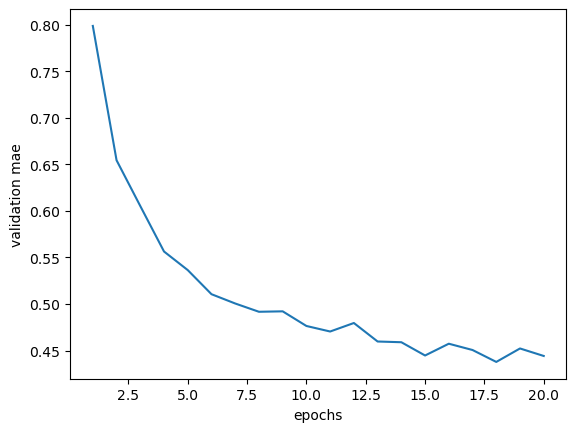

In [35]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [36]:
def smooth_curve(points, beta=0.9):
    smoothed_points = []
    for current in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(beta * previous + (1-beta) * current)
        else:
            smoothed_points.append(current)
    return smoothed_points

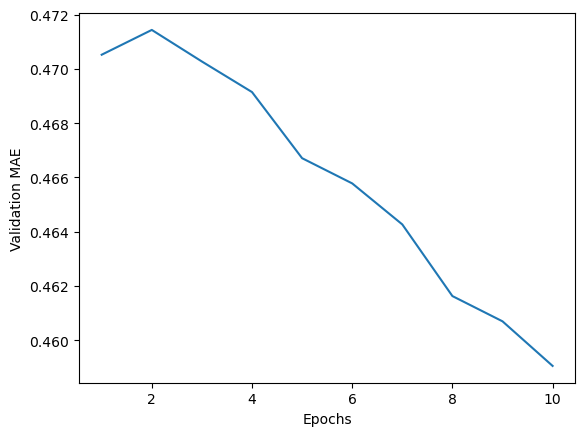

In [39]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1,len(smooth_mae_history) +1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Experiments

We want an easy way to test a lot of hyperparams:
- batch size
- lr
- layers
- units per layer
- epochs

and compare validation mae. 

questions:
- Do we want to visualize each one?

### Baseline (batch size = 1)
Mae: 0.67

In [89]:
from IPython.display import clear_output
import time


def bold_if(condition, text):
    return f"**{text}**" if condition else text

def show_experiment_log(log):
    if not log:
        return
    cols = ["#", "info", "bs", "lr", "units", "layers", "epochs", "final MAE", "best MAE", "time"]
    header = "| " + " | ".join(cols) + " |\n|" + "|".join(["---"] * len(cols)) + "|"

    best_idx = np.argmin([e['best_mae'] for e in log])

    rows = []
    for i, e in enumerate(log):
        best_str = bold_if(i == best_idx, f"{e['best_mae']:.4f} (epoch {e['best_epoch'] + 1})")
        rows.append(f"| {i+1} | {e['info']} | {e['batch_size']} | {e['lr']} | {e['units']} | {e['layers']} | {e['epochs']} | {e['final_mae']:.4f} | {best_str} | {e['elapsed']:.1f}s |")


    clear_output(wait=True)
    display(Markdown(f"{header}\n" + "\n".join(rows)))
    
def build_model(lr, units, layers):
    keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.Input((x_train.shape[1],)))
    for _ in range(layers):
        model.add(keras.layers.Dense(units, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae'],
    )
    return model

    
def run_experiment(log, epochs, lr, batch_size, units, layers, K=4, info=""):
    num_val_samples = len(x_train) // K # floor div
    all_mae_histories = []

    print(f"x train total: {len(x_train)}")
    print(f"samples per fold {num_val_samples}")

    start = time.time()


    for i in range(K):
        print('processing fold', i)
        a = i * num_val_samples
        b = a + num_val_samples
        # print(f"validation set {i} from {a} to {b}")

        # Validation data
        val_data = x_train[a:b]
        val_targets = y_train[a:b]

        # Training data
        partial_x_train = np.concatenate((x_train[:a], x_train[b:]))
        partial_train_targets = np.concatenate((y_train[:a], y_train[b:]))

        model = build_model(lr, units, layers)


        history = model.fit(partial_x_train, 
                partial_train_targets,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(val_data, val_targets),
                verbose=0,
                callbacks=[CustomCallback(epochs)],
                )

        all_mae_histories.append(history.history['val_mae'])


        avg_mae = np.array(all_mae_histories).mean(axis=0)

    elapsed = time.time() - start

    log.append(dict(
        info=info, epochs=epochs, lr=lr, batch_size=batch_size,
        units=units, layers=layers,
        final_mae=avg_mae[-1],
        best_epoch=int(np.argmin(avg_mae)),
        best_mae=avg_mae[int(np.argmin(avg_mae))],
        elapsed=elapsed,
    ))
    show_experiment_log(log)





In [48]:
#Batch size experiment
batch_sizes = [4, 8, 16, 32, 64, 128]
log = []

for bs in batch_sizes:
    run_experiment(log, 20, 0.001, bs, 64, 2)



| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 4 | 0.001 | 64 | 2 | 20 | 0.4618 | **0.4618 (epoch 20)** | 55.7s |
| 2 |  | 8 | 0.001 | 64 | 2 | 20 | 0.4887 | 0.4717 (epoch 19) | 32.2s |
| 3 |  | 16 | 0.001 | 64 | 2 | 20 | 0.5138 | 0.5036 (epoch 18) | 14.7s |
| 4 |  | 32 | 0.001 | 64 | 2 | 20 | 0.5698 | 0.5698 (epoch 20) | 9.1s |
| 5 |  | 64 | 0.001 | 64 | 2 | 20 | 0.6455 | 0.6455 (epoch 20) | 5.0s |
| 6 |  | 128 | 0.001 | 64 | 2 | 20 | 0.6887 | 0.6887 (epoch 20) | 3.5s |

### Batch size findings

Increasing batch size makes things faster.

With 1 epoch, batch size 1 is way better (0.67 vs >1.5 for 128 iirc). this is because there are way more gradient updates.
If batch size is 1 and there are 100 samples, there would be 100 weight/bias updates per epoch.
If batch size is 100 then there would be one. So it has less chances to figure itself out.

But there is a huge speed trade off.  I assume that this is because the batch size determines the amount of parallelism and also how many times we will have to send memory to the device and back.


In [50]:
# let's see how many epochs we have to add for a batch size of 128 beat a batch size of 4  with 20 epochs

epochs = [32, 64, 128, 256]
log = []
for e in epochs:
    run_experiment(log, e, 0.001, 128, 64, 2)



| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.001 | 64 | 2 | 32 | 0.6604 | 0.6604 (epoch 32) | 4.6s |
| 2 |  | 128 | 0.001 | 64 | 2 | 64 | 0.5207 | 0.5207 (epoch 64) | 8.2s |
| 3 |  | 128 | 0.001 | 64 | 2 | 128 | 0.4644 | 0.4639 (epoch 127) | 15.4s |
| 4 |  | 128 | 0.001 | 64 | 2 | 256 | 0.4485 | **0.4477 (epoch 240)** | 27.8s |

So, with a batch size of 128, we can get a better MAE than a batch size of 4, but we have to do a multiple of the epochs.

But, ths is still faster than doing batch size of 4 with 20.

We get 0.4477 with 256 epochs in 27.8s, vs atch size of 4 in 55.7s. 

We could zoom in more to see where exactly they cross, but this gives a general idea.

#### In pratice
Batch size is generally chosen based on dataset size and gpu memory limits.

And then lr and epochs are tuned for that batch size.

Next, we can look at LR, layers, and units.

In [51]:
log = []
for lr in [0.0001, 0.001, 0.01, 0.1]:
    run_experiment(log, 100, lr, 128, 64, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.0001 | 64 | 2 | 100 | 0.7732 | 0.7732 (epoch 100) | 11.9s |
| 2 |  | 128 | 0.001 | 64 | 2 | 100 | 0.4760 | 0.4760 (epoch 100) | 10.8s |
| 3 |  | 128 | 0.01 | 64 | 2 | 100 | 0.4548 | **0.4426 (epoch 97)** | 11.3s |
| 4 |  | 128 | 0.1 | 64 | 2 | 100 | 0.7395 | 0.7351 (epoch 92) | 12.3s |

In [ ]:
# lr depends on batch size, so we will likely have to go up
log = []
for lr in [0.005, 0.008, 0.01, 0.015, 0.02]:
    run_experiment(log, 100, lr, 128, 64, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.005 | 64 | 2 | 100 | 0.4556 | 0.4548 (epoch 81) | 12.2s |
| 2 |  | 128 | 0.008 | 64 | 2 | 100 | 0.4583 | 0.4474 (epoch 98) | 12.1s |
| 3 |  | 128 | 0.01 | 64 | 2 | 100 | 0.4677 | 0.4409 (epoch 84) | 13.0s |
| 4 |  | 128 | 0.015 | 64 | 2 | 100 | 0.4297 | **0.4237 (epoch 74)** | 12.6s |
| 5 |  | 128 | 0.02 | 64 | 2 | 100 | 0.4616 | 0.4389 (epoch 79) | 11.9s |

In [54]:
log = []
for u in [16, 32, 64, 128, 256]:
    run_experiment(log, 100, 0.015, 128, u, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.015 | 16 | 2 | 100 | 0.4460 | 0.4460 (epoch 100) | 11.7s |
| 2 |  | 128 | 0.015 | 32 | 2 | 100 | 0.4528 | **0.4372 (epoch 93)** | 12.6s |
| 3 |  | 128 | 0.015 | 64 | 2 | 100 | 0.4539 | 0.4463 (epoch 90) | 12.5s |
| 4 |  | 128 | 0.015 | 128 | 2 | 100 | 0.4591 | 0.4387 (epoch 92) | 12.4s |
| 5 |  | 128 | 0.015 | 256 | 2 | 100 | 0.4670 | 0.4466 (epoch 94) | 12.1s |

Unit count seems to not affect this that much.

In [55]:
log = []
for l in [1, 2, 3, 4]:
    run_experiment(log, 100, 0.015, 128, 32, l)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.015 | 32 | 1 | 100 | 0.4556 | 0.4543 (epoch 89) | 11.2s |
| 2 |  | 128 | 0.015 | 32 | 2 | 100 | 0.4542 | 0.4385 (epoch 99) | 11.9s |
| 3 |  | 128 | 0.015 | 32 | 3 | 100 | 0.4371 | **0.4300 (epoch 85)** | 12.6s |
| 4 |  | 128 | 0.015 | 32 | 4 | 100 | 0.4723 | 0.4581 (epoch 81) | 14.2s |

Finally realized big insight here, we are doing K-Fold so that we avoid choosing hyper params based on over fitting.

Our process is:
- Train
- Validate
- Tweak hyper params

We want to avoid choosing hyper params that cause over fitting.

To do this, we want to be tuning based on validation data.

K-Fold gives us more accurate validation, since it does it K times, rather than just with one validation set.

This helps us avoid tuning to a specific validation set.

So, the key is that when I am tuning these hyper params, I am looking at the best MAE across the folds, rather than the best MAE for the training set during training.  So rather than tuning based on how well the training goes internally, i'm tuning based on a more IRL test.

K-fold also reduces randomness because one could get lucky or unlucky with the break down of the training and validation data. K-Fold (esp with shuffle) avoids this more.

In [58]:
# figure out a good range for epochs by running a few times
log = []
for _ in range(5):
    run_experiment(log, 128, 0.015, 128, 32, 3)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 128 | 0.015 | 32 | 3 | 128 | 0.4938 | 0.4511 (epoch 105) | 16.8s |
| 2 |  | 128 | 0.015 | 32 | 3 | 128 | 0.4557 | 0.4433 (epoch 64) | 17.3s |
| 3 |  | 128 | 0.015 | 32 | 3 | 128 | 0.4475 | **0.4309 (epoch 79)** | 15.4s |
| 4 |  | 128 | 0.015 | 32 | 3 | 128 | 0.4457 | 0.4419 (epoch 112) | 14.6s |
| 5 |  | 128 | 0.015 | 32 | 3 | 128 | 0.4457 | 0.4435 (epoch 102) | 15.3s |

In [61]:
np.array([105, 64, 79, 112, 102]).mean()

np.float64(92.4)

So, it can take from 64 to 112 epochs (in this test), with an average of 92. 

# Conclusion

Train with our best params:

In [64]:
epochs = 92
model = build_model(0.015, 32, 3)
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs = epochs,
    verbose =0,
    callbacks=[CustomCallback(92)]
) 


model.evaluate(x_test, y_test)

\ epoch: 92/92
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4386 - mae: 0.3833


[0.43861904740333557, 0.3832932114601135]

So, our mae is 0.3833, meaning we are about $38,000 off (to 2 sf) on average.

### Testing on data points

In [68]:
predictions = model.predict(x_test).flatten()
show_data(10, test_data, y_test, predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target | Prediction | Error |
|---|---|---|---|---|---|---|---|---|---|---|---|
| 0 | -122.25 | 37.81 | 46.00 | 3232.00 | 835.00 | 1373.00 | 747.00 | 3.22 | 2.188 | 2.467 | +0.279 |
| 1 | -122.25 | 37.80 | 52.00 | 2087.00 | 510.00 | 1197.00 | 488.00 | 3.01 | 2.184 | 1.336 | -0.848 |
| 2 | -122.18 | 37.76 | 52.00 | 754.00 | 175.00 | 447.00 | 165.00 | 3.91 | 0.938 | 1.055 | +0.117 |
| 3 | -122.28 | 37.78 | 29.00 | 5154.00 | 1394.00 | 3741.00 | 1273.00 | 2.58 | 1.734 | 2.289 | +0.555 |
| 4 | -122.21 | 37.80 | 48.00 | 1321.00 | 263.00 | 506.00 | 252.00 | 4.10 | 2.297 | 2.570 | +0.273 |
| 5 | -122.16 | 37.79 | 22.00 | 12842.00 | 2048.00 | 4985.00 | 1967.00 | 5.98 | 3.710 | 2.930 | -0.780 |
| 6 | -122.25 | 37.80 | 42.00 | 4120.00 | 1065.00 | 1715.00 | 1015.00 | 2.93 | 2.250 | 2.535 | +0.285 |
| 7 | -122.16 | 37.74 | 47.00 | 824.00 | 223.00 | 533.00 | 166.00 | 2.62 | 0.982 | 1.035 | +0.053 |
| 8 | -122.29 | 37.86 | 50.00 | 2485.00 | 607.00 | 1354.00 | 563.00 | 1.95 | 1.505 | 1.497 | -0.008 |
| 9 | -122.25 | 37.86 | 48.00 | 2153.00 | 517.00 | 1656.00 | 459.00 | 3.04 | 4.896 | 1.194 | -3.702 |

In [ ]:
# On a hunch, let's see if our prediction for some areas of Oakland is super off..

# thx claude (the locations could be wrong)
lat_col = 1  # Latitude
lon_col = 0  # Longitude

# Find points near Piedmont
# for i in range(len(test_data)):
    # lat, lon = test_data[i, lat_col], test_data[i, lon_col]
    # if abs(lat - 37.82) < 0.1 and abs(lon - (-122.23)) < 0.1:
        # print(f"index {i}: lat={lat:.2f}, lon={lon:.2f}, price=${y_test[i]*100_000:,.0f}")

for i in [9, 14]:
    pred = predictions[i]
    print(f"index {i}: actual=${y_test[i]*100_000:,.0f}, predicted=${pred*100_000:,.0f}")

index 9: actual=$489,600, predicted=$119,381
index 14: actual=$500,001, predicted=$417,332


## Working with the full data set

In [87]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data()

# compute mean
mean = np.mean(train_data)

# compute std dev
std = np.std(train_data)

# normalise
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

y_train = train_targets / 100_000
y_test = test_targets / 100_000


show_data(3, x_train, y_train)

| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target |
|---|---|---|---|---|---|---|---|---|---|
| 0 | -0.59 | -0.47 | -0.46 | 1.33 | -0.06 | 0.33 | -0.11 | -0.49 | 2.523 |
| 1 | -0.59 | -0.47 | -0.48 | 0.92 | -0.06 | 0.51 | -0.06 | -0.50 | 1.469 |
| 2 | -0.59 | -0.47 | -0.46 | 0.98 | -0.16 | 0.06 | -0.19 | -0.49 | 2.909 |

In [79]:
epochs = 92
model = build_model(0.015, 32, 3)
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs = epochs,
    verbose =0,
    callbacks=[CustomCallback(92)]
) 


model.evaluate(x_test, y_test)

\ epoch: 92/92
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8411 - mae: 0.7164


[0.8410547971725464, 0.7164226770401001]

MAE on the full data set jumps to 0.7164, so we need to retune.

Let's bump up to 512 batch size for the larger data set.

In [90]:
batch_size = 512

log = []
for lr in [ 0.001, 0.01, 0.015, 0.1]:
    run_experiment(log, 32, lr, batch_size, 64, 2, 2)




| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.001 | 64 | 2 | 32 | 0.7662 | 0.7662 (epoch 32) | 13.2s |
| 2 |  | 512 | 0.01 | 64 | 2 | 32 | 0.7240 | 0.7216 (epoch 29) | 13.2s |
| 3 |  | 512 | 0.015 | 64 | 2 | 32 | 0.7241 | **0.7187 (epoch 31)** | 13.4s |
| 4 |  | 512 | 0.1 | 64 | 2 | 32 | 0.9206 | 0.8951 (epoch 9) | 14.0s |

In [91]:

log = []
for u in [16, 32, 64, 128, 256, 512]:
    run_experiment(log,32, 0.015, batch_size, u, 2, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.015 | 16 | 2 | 32 | 0.7304 | 0.7304 (epoch 32) | 13.4s |
| 2 |  | 512 | 0.015 | 32 | 2 | 32 | 0.7185 | **0.7185 (epoch 32)** | 13.3s |
| 3 |  | 512 | 0.015 | 64 | 2 | 32 | 0.7201 | 0.7198 (epoch 30) | 13.7s |
| 4 |  | 512 | 0.015 | 128 | 2 | 32 | 0.7253 | 0.7230 (epoch 24) | 14.2s |
| 5 |  | 512 | 0.015 | 256 | 2 | 32 | 0.7579 | 0.7237 (epoch 30) | 14.7s |
| 6 |  | 512 | 0.015 | 512 | 2 | 32 | 0.7598 | 0.7235 (epoch 26) | 14.0s |

In [92]:
log = []
for l in [1, 2, 3, 4]:
    run_experiment(log, 32, 0.015, batch_size, 32, l, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.015 | 32 | 1 | 32 | 0.7515 | 0.7490 (epoch 29) | 12.5s |
| 2 |  | 512 | 0.015 | 32 | 2 | 32 | 0.7486 | 0.7251 (epoch 28) | 13.2s |
| 3 |  | 512 | 0.015 | 32 | 3 | 32 | 0.7322 | 0.7222 (epoch 31) | 15.0s |
| 4 |  | 512 | 0.015 | 32 | 4 | 32 | 0.7260 | **0.7143 (epoch 31)** | 15.7s |

Struggling to get below 0.7. 

Claude thinks it's because i am normalizing incorrectly.

In [ ]:
for e in [64, 128, 256]:
    run_experiment(log, e, 0.015, batch_size, 32, 3, 2)

## Note on choosing K
i see, so it's about the jumpiness of the specifics. so like higher K for when you want to really change something between like 0.015 and 0.014 vs lower K for faster changes between like 0.01 and 0.1

In [93]:
np.mean(train_data)

np.float32(633.4512)

## Round 2

I noticed that it's hard to get below 0.7.

Claude suggets that the big issue is that i'm just getting one mean for my training data.

That is, `np.mean(train_data)` does not reutrn a vector. 
we instead want `np.mean(train_data, axis=0)` which will return a vector, with an element for each feature.

Let's try again with that change.

In [94]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data()

# compute mean
mean = np.mean(train_data, axis=0)

# compute std dev
std = np.std(train_data, axis=0)

# normalise
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

y_train = train_targets / 100_000
y_test = test_targets / 100_000


show_data(3, x_train, y_train)

| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target |
|---|---|---|---|---|---|---|---|---|---|
| 0 | 0.65 | -0.72 | 1.85 | -0.14 | 0.04 | -0.33 | -0.03 | -0.05 | 2.523 |
| 1 | 0.60 | -0.78 | -0.61 | -0.38 | 0.04 | -0.13 | 0.14 | -0.60 | 1.469 |
| 2 | -1.41 | 1.00 | 1.85 | -0.35 | -0.26 | -0.62 | -0.27 | 0.05 | 2.909 |

In [96]:
batch_size = 512

log = []
for lr in [ 0.001, 0.01, 0.015, 0.02, 0.05, 0.1]:
    run_experiment(log, 32, lr, batch_size, 64, 2, 2)


| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.001 | 64 | 2 | 32 | 0.4235 | 0.4228 (epoch 30) | 14.1s |
| 2 |  | 512 | 0.01 | 64 | 2 | 32 | 0.3851 | 0.3851 (epoch 32) | 15.5s |
| 3 |  | 512 | 0.015 | 64 | 2 | 32 | 0.4067 | 0.3763 (epoch 29) | 14.1s |
| 4 |  | 512 | 0.02 | 64 | 2 | 32 | 0.3735 | **0.3735 (epoch 32)** | 14.0s |
| 5 |  | 512 | 0.05 | 64 | 2 | 32 | 0.4077 | 0.3876 (epoch 24) | 13.3s |
| 6 |  | 512 | 0.1 | 64 | 2 | 32 | 0.9131 | 0.9057 (epoch 3) | 13.8s |

In [97]:
learning_rate = 0.02

log = []
for u in [16, 32, 64, 128, 256, 512]:
    run_experiment(log, 32, learning_rate, batch_size, u, 2, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.02 | 16 | 2 | 32 | 0.3997 | 0.3970 (epoch 30) | 13.0s |
| 2 |  | 512 | 0.02 | 32 | 2 | 32 | 0.3949 | 0.3819 (epoch 29) | 14.3s |
| 3 |  | 512 | 0.02 | 64 | 2 | 32 | 0.3744 | **0.3744 (epoch 32)** | 15.5s |
| 4 |  | 512 | 0.02 | 128 | 2 | 32 | 0.3793 | 0.3762 (epoch 23) | 15.1s |
| 5 |  | 512 | 0.02 | 256 | 2 | 32 | 0.3886 | 0.3886 (epoch 32) | 14.9s |
| 6 |  | 512 | 0.02 | 512 | 2 | 32 | 0.9125 | 0.8857 (epoch 12) | 16.8s |

In [100]:
units = 64

log = []
for l in [1, 2, 3, 4, 8, 16]:
    run_experiment(log, 32, learning_rate, batch_size, units, l, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.02 | 64 | 1 | 32 | 0.4101 | 0.4101 (epoch 32) | 12.4s |
| 2 |  | 512 | 0.02 | 64 | 2 | 32 | 0.3971 | 0.3807 (epoch 28) | 13.4s |
| 3 |  | 512 | 0.02 | 64 | 3 | 32 | 0.3782 | **0.3708 (epoch 28)** | 14.9s |
| 4 |  | 512 | 0.02 | 64 | 4 | 32 | 0.3796 | 0.3745 (epoch 31) | 15.4s |
| 5 |  | 512 | 0.02 | 64 | 8 | 32 | 0.3979 | 0.3731 (epoch 28) | 19.9s |
| 6 |  | 512 | 0.02 | 64 | 16 | 32 | 0.6866 | 0.6450 (epoch 30) | 28.3s |

4 layers is still going at 31 (not overfit, so give it more time)

If we have not yet overfit (ie if best mae is in an epoch that is not the last, then we don't really know which is best)

Like 4 layers that has not yet overfit at 31, with a higher MAE could end up better than a lower MAE 3 layers that overfits at epoch 28.

In [104]:
units = 64

log = []
for l in [3, 4, 5 ]:
    run_experiment(log, 100, learning_rate, batch_size, units, l, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.02 | 64 | 3 | 100 | 0.3618 | **0.3544 (epoch 96)** | 45.6s |
| 2 |  | 512 | 0.02 | 64 | 4 | 100 | 0.3987 | 0.3574 (epoch 87) | 47.1s |
| 3 |  | 512 | 0.02 | 64 | 5 | 100 | 0.3640 | 0.3560 (epoch 97) | 49.5s |

In [106]:
layers = 3

log = []
for e in [32, 64, 128, 256]:
    run_experiment(log, e, learning_rate, batch_size, units, layers, 2)

| # | info | bs | lr | units | layers | epochs | final MAE | best MAE | time |
|---|---|---|---|---|---|---|---|---|---|
| 1 |  | 512 | 0.02 | 64 | 3 | 32 | 0.3902 | 0.3782 (epoch 22) | 15.2s |
| 2 |  | 512 | 0.02 | 64 | 3 | 64 | 0.3660 | 0.3631 (epoch 62) | 28.4s |
| 3 |  | 512 | 0.02 | 64 | 3 | 128 | 0.3595 | **0.3553 (epoch 127)** | 55.5s |
| 4 |  | 512 | 0.02 | 64 | 3 | 256 | 0.3580 | 0.3561 (epoch 131) | 111.3s |

In [107]:
# final evaluation
epochs = 130
model = build_model(learning_rate, units, layers)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs = epochs,
    verbose =0,
    callbacks=[CustomCallback(epochs)]
) 


model.evaluate(x_test, y_test)

/ epoch: 130/130
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2871 - mae: 0.3636


[0.2871081829071045, 0.3636028468608856]

We get 0.36 MAE, so about $36,000.

Re: Batch size, having a larger batch size does not lock you out of certain results, it just forces you to change the LR to compensave. But claude also says that huge batch sizes can converge to sharper minima that can generalize worse.

### Show some predictions

In [108]:
predictions = model.predict(x_test).flatten()
show_data(10, test_data, y_test, predictions)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


| # | Longitude | Latitude | HouseAge | Population | TotalRooms | TotalBedrooms | Households | MedInc 万 | Target | Prediction | Error |
|---|---|---|---|---|---|---|---|---|---|---|---|
| 0 | -118.36 | 34.08 | 45.00 | 2195.00 | 483.00 | 1265.00 | 455.00 | 3.39 | 3.979 | 2.392 | -1.587 |
| 1 | -120.20 | 34.63 | 14.00 | 2647.00 | 515.00 | 1487.00 | 488.00 | 4.45 | 2.279 | 2.885 | +0.606 |
| 2 | -121.21 | 37.81 | 8.00 | 1883.00 | 298.00 | 999.00 | 301.00 | 5.19 | 1.721 | 1.900 | +0.179 |
| 3 | -122.06 | 37.85 | 17.00 | 7475.00 | 1556.00 | 2092.00 | 1449.00 | 3.64 | 1.865 | 2.018 | +0.153 |
| 4 | -117.40 | 33.97 | 38.00 | 1383.00 | 238.00 | 649.00 | 232.00 | 5.02 | 1.489 | 1.526 | +0.037 |
| 5 | -122.19 | 39.74 | 39.00 | 4179.00 | 814.00 | 2111.00 | 809.00 | 2.35 | 0.656 | 0.892 | +0.236 |
| 6 | -121.92 | 37.29 | 34.00 | 943.00 | 135.00 | 378.00 | 139.00 | 5.18 | 3.446 | 3.166 | -0.280 |
| 7 | -122.24 | 38.01 | 16.00 | 2084.00 | 315.00 | 1154.00 | 307.00 | 6.01 | 2.356 | 2.189 | -0.167 |
| 8 | -118.42 | 34.22 | 29.00 | 1807.00 | 323.00 | 1234.00 | 310.00 | 5.38 | 2.330 | 2.117 | -0.213 |
| 9 | -117.85 | 34.12 | 30.00 | 4367.00 | 1033.00 | 2524.00 | 954.00 | 3.04 | 1.921 | 1.893 | -0.028 |

In [109]:
# On a hunch, let's see if our prediction for some areas of Oakland is super off..

# thx claude (the locations could be wrong)
lat_col = 1  # Latitude
lon_col = 0  # Longitude

# Find points near Piedmont
# for i in range(len(test_data)):
    # lat, lon = test_data[i, lat_col], test_data[i, lon_col]
    # if abs(lat - 37.82) < 0.1 and abs(lon - (-122.23)) < 0.1:
        # print(f"index {i}: lat={lat:.2f}, lon={lon:.2f}, price=${y_test[i]*100_000:,.0f}")

for i in [9, 14]:
    pred = predictions[i]
    print(f"index {i}: actual=${y_test[i]*100_000:,.0f}, predicted=${pred*100_000:,.0f}")

index 9: actual=$192,100, predicted=$189,303
index 14: actual=$67,900, predicted=$138,834


So, it's less off in North Oakland.

## Lessons


#### Batch size
Batch size findings
Increasing batch size makes things faster.

Re: Batch size, having a larger batch size does not lock you out of certain results, it just forces you to change the LR to compensave. But claude also says that huge batch sizes can converge to sharper minima that can generalize worse.
With 1 epoch, batch size 1 is way better (0.67 vs >1.5 for 128 iirc). this is because there are way more gradient updates. If batch size is 1 and there are 100 samples, there would be 100 weight/bias updates per epoch. If batch size is 100 then there would be one. So it has less chances to figure itself out.

But there is a huge speed trade off. I assume that this is because the batch size determines the amount of parallelism and also how many times we will have to send memory to the device and back.

So, with a batch size of 128, we can get a better MAE than a batch size of 4, but we have to do a multiple of the epochs.

But, ths is still faster than doing batch size of 4 with 20.

We get 0.4477 with 256 epochs in 27.8s, vs atch size of 4 in 55.7s.

In pratice
Batch size is generally chosen based on dataset size and gpu memory limits. And then lr and epochs are tuned for that batch size.

#### Tuning
Depending on the problem, different hyper params may have more or less of an impact. Here, unit count seems to not affect this that much.


#### Why K-Fold
Finally realized big insight here, we are doing K-Fold so that we avoid choosing hyper params based on over fitting.

Our process is:

Train
Validate
Tweak hyper params
We want to avoid choosing hyper params that cause over fitting.

To do this, we want to be tuning based on validation data.

K-Fold gives us more accurate validation, since it does it K times, rather than just with one validation set.

This helps us avoid tuning to a specific validation set.

So, the key is that when I am tuning these hyper params, I am looking at the best MAE across the folds, rather than the best MAE for the training set during training. So rather than tuning based on how well the training goes internally, i'm tuning based on a more IRL test.

K-fold also reduces randomness because one could get lucky or unlucky with the break down of the training and validation data. K-Fold (esp with shuffle) avoids this more.

#### Note on choosing K
i see, so it's about the jumpiness of the specifics. so like higher K for when you want to really change something between like 0.015 and 0.014 vs lower K for faster changes between like 0.01 and 0.1

#### Importance of good normalization
Struggling to get below 0.7.

Claude suggets that the big issue is that i'm just getting one mean for my training data.

That is, np.mean(train_data) does not reutrn a vector. we instead want np.mean(train_data, axis=0) which will return a vector, with an element for each feature.


#### How to choose hyper params (don't choose before get past overfit?)
4 layers is still going at 31 (not overfit, so give it more time)

If we have not yet overfit (ie if best mae is in an epoch that is not the last, then we don't really know which is best)

Like 4 layers that has not yet overfit at 31, with a higher MAE could end up better than a lower MAE 3 layers that overfits at epoch 28.


